In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
sns.set_style('white')
np.random.seed(42)

from scipy.stats import ttest_rel
from scipy.stats import combine_pvalues

from gpu_utils import restrict_GPU_pytorch
from fig_helpers import add_metrics_to_df, adjust_box_widths

restrict_GPU_pytorch('1')

group_gap_results_df = pd.concat([pd.read_csv('results/group_gap_supervised_results'),
                            pd.read_csv('results/group_gap_ours_results'),
                            pd.read_csv('results/group_gap_scar-km2_results'),
                            pd.read_csv('results/group_gap_sar-em_results'),
                            pd.read_csv('results/group_gap_negative_results')])
label_freq_results_df = pd.concat([pd.read_csv('results/label_freq_scar-km2_results'),
                            pd.read_csv('results/label_freq_ours_results'),
                            pd.read_csv('results/label_freq_supervised_results'),
                            pd.read_csv('results/label_freq_sar-em_results'),
                            pd.read_csv('results/label_freq_negative_results')])
separability_results_df = pd.concat([pd.read_csv('results/separability_scar-km2_results'),
                            pd.read_csv('results/separability_ours_results'),
                            pd.read_csv('results/separability_cdmm_results'),
                            pd.read_csv('results/separability_supervised_results'),
                            pd.read_csv('results/separability_sar-em_results'),
                            pd.read_csv('results/separability_negative_results')])

group_gap_results_df = add_metrics_to_df(group_gap_results_df)
label_freq_results_df = add_metrics_to_df(label_freq_results_df)
separability_results_df = add_metrics_to_df(separability_results_df)

val_loss_key = 'auc'

orig = sns.color_palette('colorblind')
method_colors = [orig[2], orig[0], orig[1], orig[3], orig[4]]
method_colors = ['#4daf4a', '#e41a1c', '#377eb8', '#ff7f00', '#984ea3']
hue_order = ['supervised', 'negative', 'scar-km2', 'sar-em', 'ours']
plotted_methods = ['supervised', 'negative', 'scar-km2', 'sar-em', 'ours']
method_name_dict = {"supervised": "Supervised", "negative": "Negative", "scar-c": "SCAR-C",
                    'scar-km2': 'KM2', "sar-em": "EM", "ours": "PURPLE"}

Using GPU:1


# Figure 2a: Performance under different separability conditions.

<ipython-input-17-04789bfeeb49>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(["", "",  "0.5x", "1.0x", "2.0x"])
<ipython-input-17-04789bfeeb49>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(["", "",  "0.5x", "1.0x", "2.0x"])


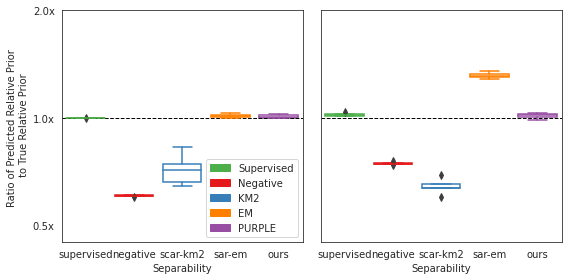

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
modes = ['separable', 'overlap']
for i, mode in enumerate(modes):
    our_results = separability_results_df[separability_results_df['method'] == 'ours']
    other_results = separability_results_df[separability_results_df['method'] != 'ours']
    our_results = our_results.sort_values([val_loss_key], ascending=False).groupby(['labeling_frequency_g2', 'run', 'separability_assumption']).head(1)
    expmt_results = pd.concat([our_results, other_results])
    expmt_results = expmt_results[expmt_results['separability_assumption'] == mode]
    
    g = sns.boxplot(x='method', y='rel_prior_err_pct', 
                     data=expmt_results, 
                     order=hue_order, ax=axs[i], zorder=2)
    
    g.set_yscale('log', base=2)
    axs[i].set_xlabel("Separability")
    axs[i].axhline(y=1.0, color='black', linestyle='--', zorder=1,
                   linewidth=1)
    if i == 0:
        axs[i].set_ylabel("Ratio of Predicted Relative Prior \n to True Relative Prior")
    else:
        axs[i].set_ylabel("")
    
    # Change the color of the entire box to be method color
    for j,box in enumerate(axs[i].artists):
        color = method_colors[j]
        box.set_edgecolor(color)
        box.set_facecolor('white')
        for k in range(6*j,6*(j+1)):
             axs[i].lines[k].set_color(color)
                
    axs[i].set_ylim([.45, 2.0])
    axs[i].set_yticklabels(["", "",  "0.5x", "1.0x", "2.0x"])

# Make legend
patches = []
for method_name, method_color in zip(hue_order, method_colors):
    patches.append(mpatches.Patch(color=method_color, label=method_name))
labels = [method_name_dict[m] for m in hue_order]
axs[0].legend(handles = patches, labels = labels,loc = 'lower right')

    
plt.tight_layout()

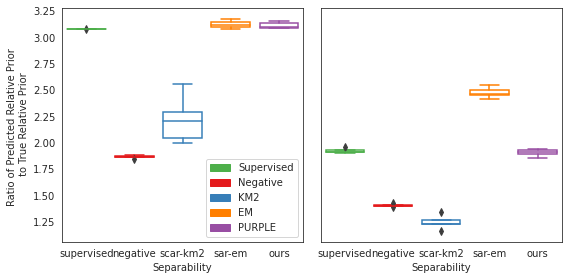

In [313]:
# Plot the absolute predicted relative prior 

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
modes = ['separable', 'overlap']
for i, mode in enumerate(modes):
    
    our_results = separability_results_df[separability_results_df['method'] == 'ours']
    other_results = separability_results_df[separability_results_df['method'] != 'ours']
    our_results = our_results.sort_values([val_loss_key], ascending=False).groupby(['labeling_frequency_g2', 'run', 'separability_assumption']).head(1)
    expmt_results = pd.concat([our_results, other_results])
    expmt_results = expmt_results[expmt_results['separability_assumption'] == mode]
    
    g = sns.boxplot(x='method', y='pred_rel_prior', 
                     data=expmt_results, 
                     order=hue_order, ax=axs[i], zorder=2)
    
    axs[i].set_xlabel("Separability")
    
    if i == 0:
        axs[i].set_ylabel("Predicted Relative Prior")
    else:
        axs[i].set_ylabel("")
    for j,box in enumerate(axs[i].artists):
        color = method_colors[j]
        box.set_edgecolor(color)
        box.set_facecolor('white')
        for k in range(6*j,6*(j+1)):
             axs[i].lines[k].set_color(color)

patches = []
for method_name, method_color in zip(hue_order, method_colors):
    patches.append(mpatches.Patch(color=method_color, label=method_name))
labels = [method_name_dict[m] for m in hue_order]
axs[0].legend(handles = patches, labels = labels,loc = 'lower right')

    
plt.tight_layout()

# Figure 2b: Performance under different Labeling Frequencies

<ipython-input-19-ec97c29495b1>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(["","", "0.5x", "1.0x", "2.0x"])


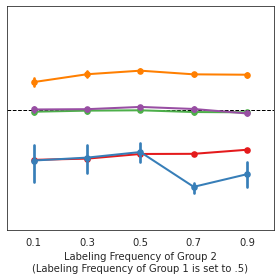

In [19]:
plt.figure(figsize=(4,4))

label_freq_results_df['labeling_frequency_g2'] = label_freq_results_df['labeling_frequency_g2'].round(2)
label_freq_results_df = label_freq_results_df[label_freq_results_df['labeling_frequency_g2'].isin([.1, .3, .5, .7, .9])]
label_freq_results_df = label_freq_results_df[label_freq_results_df['method'].isin(plotted_methods)]

# Select performance our method based on val_loss_key
our_results = label_freq_results_df[label_freq_results_df['method'] == 'ours']
other_results = label_freq_results_df[label_freq_results_df['method'] != 'ours']
our_results = our_results.sort_values([val_loss_key], ascending=False).groupby(['labeling_frequency_g2', 'run', 'separability_assumption']).head(1)
label_freq_results_df = pd.concat([our_results, other_results])

plt.axhline(y=1, color='black', linestyle='--', zorder=1,
           linewidth=1)
g = sns.pointplot(x='labeling_frequency_g2', y='rel_prior_err_pct', 
            hue='method', data=label_freq_results_df, hue_order=plotted_methods, 
              palette=method_colors,
             linestyles=['-', '-', '-', '-', '-'], err_style='bars',
             scale=.75, zorder=2, legend_out=False)

g.set_yscale('log', base=2)
g.set_ylim(.45, 2.0)
g.set_yticklabels(["","", "0.5x", "1.0x", "2.0x"])
g.set_yticklabels([])
g.get_legend().remove()

plt.xlabel("Labeling Frequency of Group 2\n(Labeling Frequency of Group 1 is set to .5)")
plt.ylabel("")
plt.tight_layout()

# Figure  2c: Performance under different levels of covariate shift

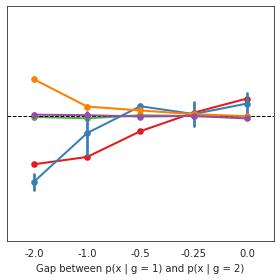

In [20]:
plt.figure(figsize=(4,4))

group_gap_results_df = group_gap_results_df[group_gap_results_df['method'].isin(plotted_methods)]

# Select performance our method based on val_loss_key
our_results = group_gap_results_df[group_gap_results_df['method'] == 'ours']
other_results = group_gap_results_df[group_gap_results_df['method'] != 'ours']
our_results = our_results.sort_values([val_loss_key], ascending=False).groupby(['group_gap', 'run']).head(1)
group_gap_results_df = pd.concat([our_results, other_results])


g = sns.pointplot(x='group_gap', y='rel_prior_err_pct', hue='method', data=group_gap_results_df, 
            hue_order = plotted_methods, scale=.75, 
            linestyles=['-', '-', '-', '-', '-'], palette=method_colors)
plt.xlabel("Gap between p(x | g = 1) and p(x | g = 2)")

g.set_yscale('log', base=2)
g.set_ylim(.45, 2.0)
g.set_yticklabels([])
plt.ylabel("")

plt.axhline(y=1.0, color='black', linestyle='--', zorder=1,
            linewidth=1)
g.get_legend().remove()
plt.tight_layout()

# Statistical Comparisons

In [21]:
# Across separability assumptions
sep_assumption = 'overlap'
for sep_assumption in ['separable', 'overlap']:
    for method in plotted_methods: 
        if method == 'ours' or method == 'supervised':
            continue
        print("Separability Assumption: ", sep_assumption, "Method: ", method)
        expmt_results = separability_results_df[separability_results_df['separability_assumption'] == sep_assumption]
        our_results = expmt_results[expmt_results['method'] == 'ours']
        other_method_results = expmt_results[expmt_results['method'] == method]
        print(ttest_rel(our_results['log_rel_prior_err_pct'], other_method_results['log_rel_prior_err_pct']))
        print()

Separability Assumption:  separable Method:  negative
Ttest_relResult(statistic=205.93123095098753, pvalue=3.335754791793739e-09)

Separability Assumption:  separable Method:  scar-km2
Ttest_relResult(statistic=8.182843161071848, pvalue=0.0012147470512699431)

Separability Assumption:  separable Method:  sar-em
Ttest_relResult(statistic=-0.5950669341277632, pvalue=0.5838289301954438)

Separability Assumption:  overlap Method:  negative
Ttest_relResult(statistic=57.58469097623957, pvalue=5.445659242566299e-07)

Separability Assumption:  overlap Method:  scar-km2
Ttest_relResult(statistic=17.746128586449878, pvalue=5.923776202020907e-05)

Separability Assumption:  overlap Method:  sar-em
Ttest_relResult(statistic=-70.85150216450798, pvalue=2.37781718295864e-07)



In [22]:
# Across label frequencies
max_pvals = []
for label_freq in [.1, .3, .5, .7, .9]:
    pvals = []
    for method in plotted_methods: 
        if method == 'ours' or method == 'supervised':
            continue
        expmt_results = label_freq_results_df[label_freq_results_df['labeling_frequency_g2'] == label_freq]
        our_results = expmt_results[expmt_results['method'] == 'ours']
        other_method_results = expmt_results[expmt_results['method'] == method]
        x, pval = ttest_rel(our_results['log_rel_prior_err_pct'], other_method_results['log_rel_prior_err_pct'])
        pvals.append(pval)
        print("Label Frequency: ", label_freq, "Method: ", method, 'p-val: ', pval)
    max_pvals.append(np.max(pvals))
print(combine_pvalues(max_pvals))
# Across covariate shifts

Label Frequency:  0.1 Method:  negative p-val:  4.0099459029364925e-06
Label Frequency:  0.1 Method:  scar-km2 p-val:  0.016472903874126307
Label Frequency:  0.1 Method:  sar-em p-val:  0.0007368709571952222
Label Frequency:  0.3 Method:  negative p-val:  1.2342109345150793e-06
Label Frequency:  0.3 Method:  scar-km2 p-val:  0.0040147986445615005
Label Frequency:  0.3 Method:  sar-em p-val:  9.892809341756885e-05
Label Frequency:  0.5 Method:  negative p-val:  6.400936109806032e-07
Label Frequency:  0.5 Method:  scar-km2 p-val:  0.00117250939416125
Label Frequency:  0.5 Method:  sar-em p-val:  1.6200512788720046e-05
Label Frequency:  0.7 Method:  negative p-val:  8.670214320923108e-06
Label Frequency:  0.7 Method:  scar-km2 p-val:  1.1122916860932053e-05
Label Frequency:  0.7 Method:  sar-em p-val:  3.92608533452191e-05
Label Frequency:  0.9 Method:  negative p-val:  2.1969000789601827e-06
Label Frequency:  0.9 Method:  scar-km2 p-val:  0.0010042890476931207
Label Frequency:  0.9 Metho

In [23]:
# Across label frequencies
max_pvals = []
for group_gap in list(set(group_gap_results_df['group_gap'])):
    pvals = []
    for method in plotted_methods: 
        if method == 'ours' or method == 'supervised':
            continue
        expmt_results = group_gap_results_df[group_gap_results_df['group_gap'] == group_gap]
        our_results = expmt_results[expmt_results['method'] == 'ours']
        other_method_results = expmt_results[expmt_results['method'] == method]
        x, pval = ttest_rel(our_results['log_rel_prior_err_pct'], other_method_results['log_rel_prior_err_pct'])
        pvals.append(pval)
        print("Group gap: ", group_gap, "Method: ", method, 'p-val: ', pval)
    max_pvals.append(np.max(pvals))
print(combine_pvalues(max_pvals))
# Across covariate shifts

Group gap:  -0.5 Method:  negative p-val:  2.748881577593179e-06
Group gap:  -0.5 Method:  scar-km2 p-val:  0.010633664208582309
Group gap:  -0.5 Method:  sar-em p-val:  0.010475297451309335
Group gap:  -0.25 Method:  negative p-val:  0.0028987687200010127
Group gap:  -0.25 Method:  scar-km2 p-val:  0.8359051811881766
Group gap:  -0.25 Method:  sar-em p-val:  0.16573882491150782
Group gap:  0.0 Method:  negative p-val:  9.575822995282794e-07
Group gap:  0.0 Method:  scar-km2 p-val:  0.12070159527971555
Group gap:  0.0 Method:  sar-em p-val:  0.0016831032851828674
Group gap:  -1.0 Method:  negative p-val:  7.147625281676033e-06
Group gap:  -1.0 Method:  scar-km2 p-val:  0.202902463735169
Group gap:  -1.0 Method:  sar-em p-val:  0.009971846559140723
Group gap:  -2.0 Method:  negative p-val:  3.956549685758413e-06
Group gap:  -2.0 Method:  scar-km2 p-val:  0.00011196306611149921
Group gap:  -2.0 Method:  sar-em p-val:  8.421725206321955e-05
(35.05955173021826, 0.00012197675019500667)


# Train a baseline  on simulated data

In [32]:
import torch

from sarpu.pu_learning import *
from eval_fs import eval_relative_prior
from method import train_relative_estimator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from simulation_helpers import create_gap_1d, create_gap_nd
from simulation_helpers import generate_g, generate_y, generate_s_scar
from simulation_helpers import separable_decision_rule_1d, inseparable_decision_rule_1d
from simulation_helpers import separable_decision_rule_nd, inseparable_decision_rule_nd

from method import train_relative_estimator, get_loss
from baselines import cdmm, supervised_rel_prior, sar_em_rel_prior, scar_km2_rel_prior

R[write to console]: Installing packages into ‘/mnt/hdd/home/divyas/R/x86_64-pc-linux-gnu-library/4.0’
(as ‘lib’ is unspecified)



### Generating data for each group.

Parameters that you can plan with are $c_1$, $c_2$, group_gap, and separability assumption ('separable', 'overlap', 'overlaid'). In addition, you can change std, the standard deviation of the Gaussian distributions for each group, n_to_sample, and n_attributes.

In [33]:
# Parameter settings
c1 = .5
c2 = .3
n_groups = 2
group_gap = -2
scar_assumption = True
separability_assumption = 'overlap'
std, n_to_sample, n_attributes = 16, 10000, 5
n_to_sample_g1 = n_to_sample
n_to_sample_g2 = 2*n_to_sample

g1_mean = np.ones(n_attributes)
g2_mean =  g1_mean + group_gap
g1_config = {'mean': g1_mean, 'std': std, 'n_samples': n_to_sample_g1, 
             'n_attributes': n_attributes, 'n_groups': n_groups, 'group_feat': 1}
g2_config = {'mean': g2_mean, 'std': std, 'n_samples': n_to_sample_g2, 
             'n_attributes': n_attributes, 'n_groups': n_groups, 'group_feat': 2}

expmt_config = {'scar_assumption': scar_assumption, 
                'separability_assumption': separability_assumption, 
                'labeling_frequency_g1': c1, 'labeling_frequency_g2': c2} 

In [34]:
x1 = generate_g(g1_config)
x2 = generate_g(g2_config)

if expmt_config['separability_assumption'] == 'separable':
    y1 = generate_y(x1, g1_config, separable_decision_rule_nd)
    y2 = generate_y(x2, g2_config, separable_decision_rule_nd)
    x1, y1 = create_gap_nd(x1, y1, g1_config)
    x2, y2 = create_gap_nd(x2, y2, g2_config)
elif expmt_config['separability_assumption'] == 'overlap':
    y1, p_y1 = generate_y(x1, g1_config, inseparable_decision_rule_nd, beta=1)
    y2, p_y2 = generate_y(x2, g2_config, inseparable_decision_rule_nd, beta=1)
elif expmt_config['separability_assumption'] == 'overlaid':
    beta = 1
    y1 = generate_y(x1, g1_config, inseparable_decision_rule_nd, beta=.75, scale=.75)
    y2 = generate_y(x2, g2_config, inseparable_decision_rule_nd, beta=.75, scale=.75)

# generate observed labels
if expmt_config['scar_assumption']:
    s1 = generate_s_scar(y1, expmt_config['labeling_frequency_g1'])
    s2 = generate_s_scar(y2, expmt_config['labeling_frequency_g2'])


# split into train, val, test
x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])
s = np.concatenate([s1, s2])

### Splitting  x, y, and s into train and test sets.

We assume that the data is stratified by group across the train and test set. That is, p(g=1) is constant across each split.

In [35]:
x1_train, x1_test, y1_train, y1_test, s1_train, s1_test = train_test_split(x1, y1, s1, test_size=.2, 
                                                                                  random_state=10, shuffle=True, stratify=y1)
x2_train, x2_test, y2_train, y2_test, s2_train, s2_test = train_test_split(x2, y2, s2, test_size=.2, 
                                                                                  random_state=10, shuffle=True, stratify=y2)

x_train = np.concatenate([x1_train, x2_train])
y_train = np.concatenate([y1_train, y2_train])
s_train = np.concatenate([s1_train, s2_train])

x_test = np.concatenate([x1_test, x2_test])
y_test = np.concatenate([y1_test, y2_test])
s_test = np.concatenate([s2_test, s2_test])

scale_factor = np.max(np.abs(x_train))
x_train_norm = x_train/scale_factor
x_test_norm = x_test/scale_factor

g1_train_idxs = x_train[:,0] == 1
g2_train_idxs = x_train[:,1] == 1
g1_test_idxs = x_test[:,0] == 1
g2_test_idxs = x_test[:,1] == 1
classification_attributes = [i + n_groups for i in range(n_attributes)]

### Quick summary of the group statistics:

In [36]:
print("--- Group-specific p(y=1) --- ")
print("p( y = 1 | g = 1 )", np.mean(y1))
print("p( y = 1 | g = 2 )", np.mean(y2))

print("--- Group-specific p(s=1) --- ")
print("p( s = 1 | g = 1 )", np.mean(s1))
print("p( s = 1 | g = 2 )", np.mean(s2))

print("--- Number of Samples ---")
print(len(x))

--- Group-specific p(y=1) --- 
p( y = 1 | g = 1 ) 0.6504
p( y = 1 | g = 2 ) 0.3444
--- Group-specific p(s=1) --- 
p( s = 1 | g = 1 ) 0.3252
p( s = 1 | g = 2 ) 0.1033
--- Number of Samples ---
30000


# Train a baseline

In [37]:
method = 'supervised'
if method == 'supervised':
    results = supervised_rel_prior(x_train[g1_train_idxs], 
                                   x_train[g2_train_idxs],
                                   y1_train, y2_train, x_test, g1_config)

    pred_rel_prior, pred_g1_prior, pred_g2_prior, models = results
    f1_model, f2_model = models

elif method == 'negative':
    results = supervised_rel_prior(x_train[g1_train_idxs], 
                                   x_train[g2_train_idxs],
                                   s_train[g1_train_idxs],
                                   s_train[g2_train_idxs], x_test, g1_config)

    pred_rel_prior, pred_g1_prior, pred_g2_prior, models = results
    f1_model, f2_model = models

elif method == 'sar-em':
    results = sar_em_rel_prior(x_train_norm[g1_train_idxs],
                               x_train_norm[g2_train_idxs],
                               s_train[g1_train_idxs],
                               s_train[g2_train_idxs], x_test_norm, g1_config)

    pred_rel_prior, pred_g1_prior, pred_g2_prior,  models = results
    f1_model, f2_model = models
    
elif method == 'cdmm':
    results  = cdmm(x_train_norm[g1_train_idxs], x_train_norm[g2_train_idxs],
                s_train[g1_train_idxs], s_train[g2_train_idxs], g1_config)

    pred_rel_prior, pred_g1_prior, pred_g2_prior, models = results
    f1_model, f2_model = models
    
elif method == 'scar-km2':
    results = scar_km2_rel_prior(x1_train, x2_train, s1_train, s2_train)
    pred_rel_prior, pred_g1_prior, pred_g2_prior, models = results
    f1_model, f2_model = models

Text(0.5, 0, 'Signed distance from hyperplane')

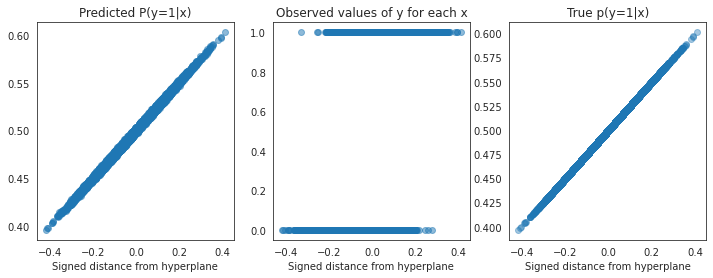

In [39]:
# Visualize predictions on training data
n_dims = g1_config['n_attributes']
y_pred = f1_model.model.predict_proba(x_train_norm[:,2:])[:,1]
ortho_normal = np.expand_dims(1*np.ones(n_attributes), 0)
features_train = np.dot(ortho_normal, x_train_norm[:,2:].T)
normalization = np.dot(ortho_normal, ortho_normal.T)[0][0]
features_train = features_train/normalization
y_true = (1/(1 + np.exp(-features_train*1)))

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].scatter(features_train[0], y_pred, label='pred', alpha=.5)
axs[0].set_title("Predicted P(y=1|x)")
axs[0].set_xlabel("Signed distance from hyperplane")

axs[1].scatter(features_train[0], y_train, label='true', alpha=.5)
axs[1].set_title("Observed values of y for each x")
axs[1].set_xlabel("Signed distance from hyperplane")

axs[2].scatter(features_train[0], y_true, label='p(y)', alpha=.4)
axs[2].set_title("True p(y=1|x)")
axs[2].set_xlabel("Signed distance from hyperplane")

(1, 6000) (6000,)


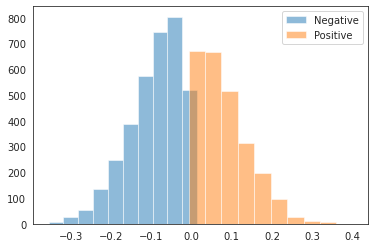

In [42]:
# Visualize predictions on test data 
y_pred = f1_model.predict_proba(x_test_norm)
ortho_normal = np.expand_dims(1*np.ones(n_attributes), 0)
features_test = np.dot(ortho_normal, x_test_norm[:,2:].T)
normalization = np.dot(ortho_normal, ortho_normal.T)[0][0]
features_test = features_test/normalization
binarized_y_pred = (y_pred > .5).astype(int)
print(features_test.shape, y_pred.shape)
plt.hist(features_test[0, binarized_y_pred == 0], alpha=.5, label='Negative')
plt.hist(features_test[0, binarized_y_pred == 1], alpha=.5, label='Positive')
plt.legend()

In [43]:
pred_rel_prior, pred_g1_prior, pred_g2_prior = eval_relative_prior(x_test, f1_model, 
                                                                   f2_model)
true_g1_prior = y_test[g1_test_idxs].mean()
true_g2_prior = y_test[g2_test_idxs].mean()
print("Pred G1 Prior: ", pred_g1_prior, "Pred G2 Prior: ", pred_g2_prior)
print("True G1 Prior: ", true_g1_prior, "True G2 Prior: ", true_g2_prior)
print("True Relative Prior: ", true_g1_prior/true_g2_prior)
print("Pred Relative Prior: ", pred_g1_prior/pred_g2_prior)
print("Rel Error:", (pred_g1_prior/pred_g2_prior) / (true_g1_prior/true_g2_prior) )

Pred G1 Prior:  0.6501237775320685 Pred G2 Prior:  0.33652430488901225
True G1 Prior:  0.6505 True G2 Prior:  0.3445
True Relative Prior:  1.888243831640058
Pred Relative Prior:  1.9318776328695881
Rel Error: 1.0231081391599894


# Train our model

/mnt/hdd/home/divyas/invisible_conditions/relative_prevalence_benchmark/method.py:82: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.p_y_coeffs.weight)
/mnt/hdd/home/divyas/invisible_conditions/relative_prevalence_benchmark/method.py:83: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.c_g_coeffs.weight)
100%|██████████| 10000/10000 [00:31<00:00, 315.01it/s]


Text(0, 0.5, 'CE Loss')

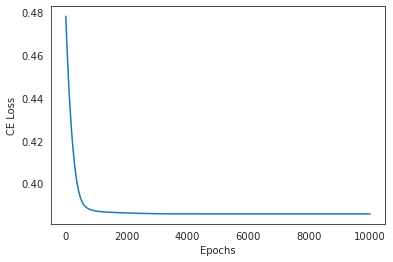

In [44]:
# Set regularization parameter
n_epochs = 10000
g1_config['lamda'] = 0
f_model, losses = train_relative_estimator(x_train, s_train, g1_config, n_epochs=n_epochs)
pred_rel_prior, pred_g1_prior, pred_g2_prior = eval_relative_prior(x_test, f_model)
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("CE Loss")

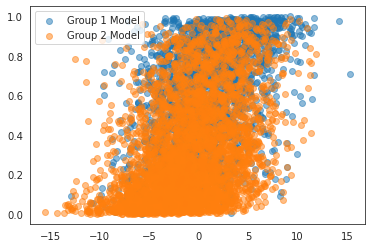

In [45]:
# Visual check to see if the same decision rule is learned for both group 1 & group 2
y1_test_pred = f_model.estimate_p_y(torch.Tensor(x_test[g1_test_idxs]).cuda()).detach().cpu().numpy().squeeze()
y2_test_pred = f_model.estimate_p_y(torch.Tensor(x_test[g2_test_idxs]).cuda()).detach().cpu().numpy().squeeze()
plt.scatter(x_test[g1_test_idxs,2], y1_test_pred,  alpha=.5, label='Group 1 Model')
plt.scatter(x_test[g2_test_idxs,2], y2_test_pred, alpha=.5, label='Group 2 Model')
plt.legend()

In [47]:
# Looking at weights - based on generative model, weights are equal to one another in the true solution
f_model.p_y_coeffs.weight, f_model.p_y_coeffs.bias, f_model.get_c_g()

(Parameter containing:
 tensor([[0.1928, 0.1917, 0.1845, 0.1951, 0.1899]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([-0.1549], device='cuda:0', requires_grad=True),
 tensor([[0.4526, 0.2662]], device='cuda:0', grad_fn=<SigmoidBackward>))

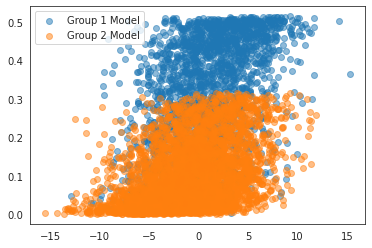

In [49]:
# Plot p(s|x)
s1_test_pred = f_model(torch.Tensor(x_test[g1_test_idxs]).cuda()).detach().cpu().numpy().squeeze()
s2_test_pred = f_model(torch.Tensor(x_test[g2_test_idxs]).cuda()).detach().cpu().numpy().squeeze()

plt.scatter(x_test[g1_test_idxs,2], s1_test_pred,  alpha=.5, label='Group 1 Model')
plt.scatter(x_test[g2_test_idxs,2],s2_test_pred, alpha=.5, label='Group 2 Model')
plt.legend()

In [50]:
true_g1_prior = y_test[g1_test_idxs].mean()
true_g2_prior = y_test[g2_test_idxs].mean()
print("Pred G1 Prior: ", pred_g1_prior, "Pred G2 Prior: ", pred_g2_prior)
print("True G1 Prior: ", true_g1_prior, "True G2 Prior: ", true_g2_prior)
print("True Relative Prior: ", true_g1_prior/true_g2_prior)
print("Pred Relative Prior: ", pred_rel_prior)

Pred G1 Prior:  0.6219102144241333 Pred G2 Prior:  0.31735819578170776
True G1 Prior:  0.6505 True G2 Prior:  0.3445
True Relative Prior:  1.888243831640058
Pred Relative Prior:  1.959647536277771
